# Graph Convolutional Network

My attempt at building a simple 2-layer Graph Convolution Neural Network for graph classification with Pytorch.

Utilises the definitions and architecture outlined in _Kipf & Welling, [Semi-Supervised Classification with Graph Convolutional Networks](http://arxiv.org/abs/1609.02907) (ICLR 2017)_.

## Imports and dataset

In [2]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.sparse as sps
import torch
from torch import nn

%matplotlib inline

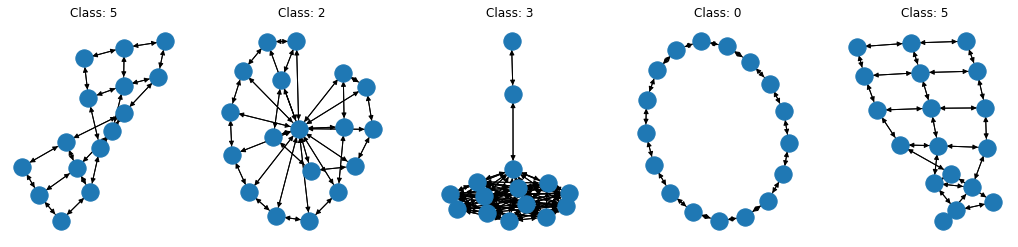

In [3]:
gcdataset = MiniGCDataset(50,10,20)

# convert DGLgraph to networkx
# each entry in dataset: (networkx graph, label)
dataset = []
for i in np.arange(50):
    graph, label = gcdataset[i]
    dataset.append( (graph.to_networkx(), label) )
    
# show samples from dataset
plt.figure(figsize=(18,4))
for i, g in enumerate(np.random.randint(0, 50, 5)):
    graph, label = dataset[g]
    plt.subplot(1,5,i+1)
    nx.draw(graph)
    plt.title('Class: {}'.format(label));

## GCN construction

A graph convolution is defined as follows (eqn. 8 in _Kipf & Welling_). 

For a signal $X \in \mathbb{R}^{N \times C}$ with $N$ nodes and $C$ input channels, and $F$ filters or feature maps:
$$ Z = \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} X \Theta ,$$

where:
* $Z \in \mathbb{R}^{N \times F}$ is the convolved signal matrix
* $\Theta \in \mathbb{R}^{C \times F}$ is a matrix of filter parameters
* $\tilde{A} = A + I_N$ is the adjacency matrix A with added self-connections
* $\tilde{D} = \sum_j \tilde{A}_{ij}$ is the degree matrix of the new adjacency matrix

Here a _renormalisation trick_ is performed, such that the rescaled, normalised graph Laplacian with self-loops is expressed by $\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}$.

In [ ]:
class GCNLayer(nn.Module):
    
    def __init__(self, C, F):
        super(GCNLayer, self).__init__()
        self.ϴ = nn.Linear(in_features=C, out_features=F)
        
    def forward(self, X):
        A = nx.adjacency_matrix(X)
        

In [ ]:
X = dataset[0][0]

N = X.number_of_nodes()

ϴ = nn.Linear(in_features=N, out_features=3)
A = torch.Tensor( nx.adjacency_matrix(X).todense() ) # A = dense adj. matrix as Tensor

A_tilde = A + torch.eye(N) # add self-connections
D_tilde = torch.sum(A_tilde, 1) # degree matrix of A_tilde
D_tilde_half = (D_tilde + 1e-5) ** (-0.5)
L_tilde = D_tilde_half * A * D_tilde_half # rescaled normalised graph Laplacian

Z = ϴ(torch.mm(L_tilde, A))
Z